# kNN & Clustering

__Суммарное количество баллов: 10 + 3 bonus__

## kNN, рак и спам

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from sklearn import model_selection, metrics
from sklearn.neighbors import KDTree
from math import *

### Задание 1 (1 балл)

#### 1. (0.5 балла)
Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [2]:
CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv'

In [3]:
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.label
    X = df.drop(columns=['label'])
    return X, y

def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.label
    X = df.drop(columns=['label'])
    return X, y

In [4]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

In [5]:
y_cancer = y_cancer.replace({'M': 1, 'B': 0})
y_cancer

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: label, Length: 569, dtype: int64

In [6]:
y_spam

0       1
1       1
2       1
3       1
4       1
       ..
4596    0
4597    0
4598    0
4599    0
4600    0
Name: label, Length: 4601, dtype: int64

#### 2. (0.5 балла) 

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [7]:
def train_test_split(X, y, ratio):
    X_train, y_train, X_test, y_test = model_selection.train_test_split(X, y, test_size=1-ratio)
    return X_train, y_train, X_test, y_test 

### Задание 2 (1.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [8]:
def get_precision_recall_accuracy(y_pred, y_true):
    y_true_re = y_true.replace({0: 1, 1: 0})
    y_pred_re = 1 - y_pred
    precision = [metrics.precision_score(y_true, y_pred),\
                metrics.precision_score(y_true_re, y_pred_re)]    
    recall = [metrics.recall_score(y_true, y_pred),\
                metrics.recall_score(y_true_re, y_pred_re)]    
    accuracy = [metrics.accuracy_score(y_true, y_pred),\
                metrics.accuracy_score(y_true_re, y_pred_re)]
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [9]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [10]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 3  (3 балла)


## 1. (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [11]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.h = n_neighbors
        self.kernel_f = lambda x: 2 / pi / (e ** x + e ** (-x))
        self.leaf_size = leaf_size
        
    def fit(self, X_train, y_train):
        X_train = X_train.to_numpy()
        y_train = y_train.to_numpy()
        self.kd_tree = KDTree(X_train, leaf_size=self.leaf_size)
        self.X_train = X_train
        self.y_train = y_train

    def predict_proba(self, X):
        X = X.to_numpy()
        predicted = []
        for line in X:
            predicted.append(self.predict_proba_one(line))
        return predicted
    
    def predict_proba_one(self, X):
        distances, indices = self.kd_tree.query(X.reshape(1, -1), k=self.h)
        distances = distances[0]
        indices = indices[0]
        win_result = max(d for d in distances)
        weighted_y = [0 for _ in range(2)]
        weights_sum = 0
        predicted = []
        for dist, ind in zip(distances, indices):
            weight = self.kernel_f(dist / win_result) if win_result != 0 else 0
            for j in range(2):
                weighted_y[j] += weight * (1 if self.y_train[ind] == j else 0)
            weights_sum += weight
        for j in range(2):
            if weights_sum != 0:
                predicted.append(weighted_y[j] / weights_sum)
            else:
                predicted.append(1 - np.mean(self.y_train) if j == 0 else np.mean(self.y_train))
                    
        return predicted
        
    def predict(self, X):
        predicted = self.predict_proba(X)
        return pd.Series(np.argmax(predicted, axis=1))


Наконец, протестируем наш классификатор на различных наборах данных

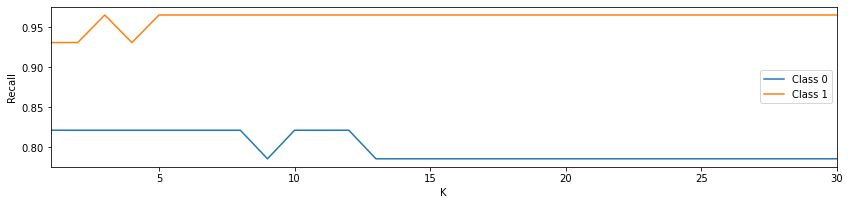

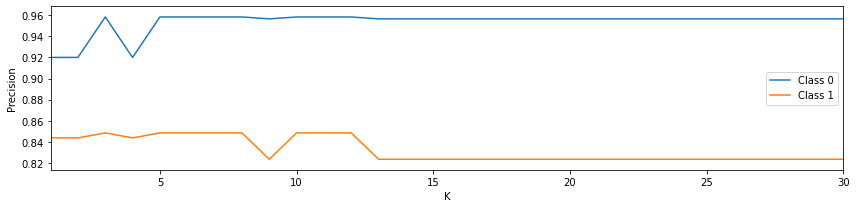

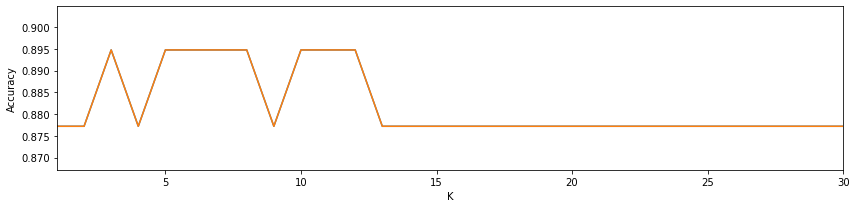

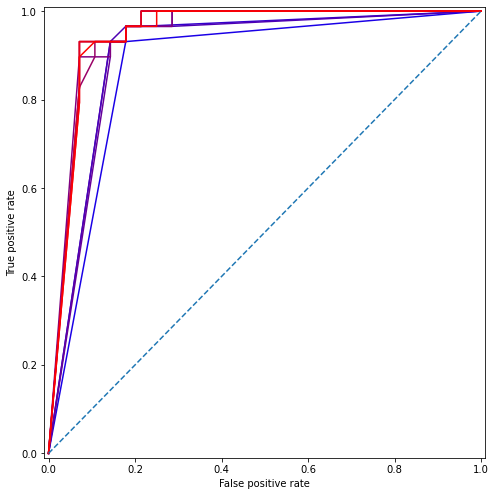

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

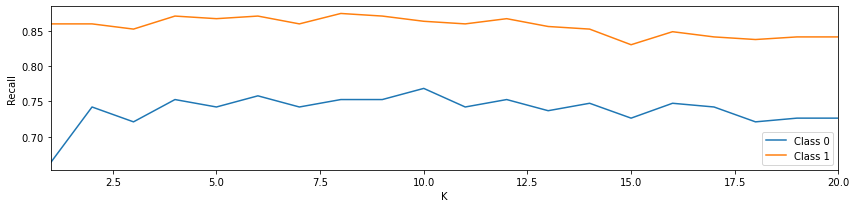

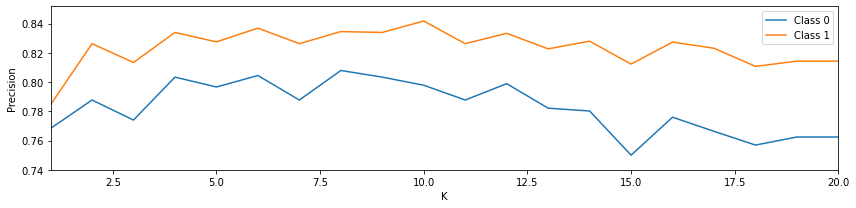

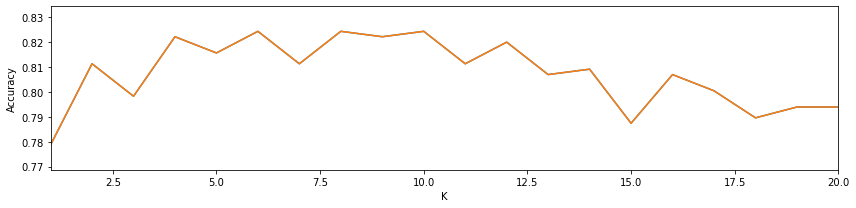

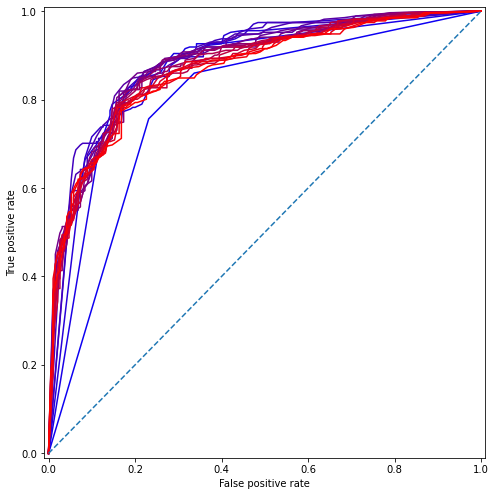

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_spam, y_spam, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

#### 2. (1.5 балла)

Проанализируйте полученные графики. Какой параметр `k` кажется лучшим для каждой из задач? Какая из метрик лучше всего отражает качество модели? 

В первом датасете важно не пропустить пациентов с раком, поэтому нам надо, чтобы false negative был минимален, а вот false positive нам не так важен. С этим может помочь recall. По accuracy оптимальным кажется k = 7.

Во втором датасете лучше всего k=6. Тут наоборот важнее не отправить нормальное письмо в спам, то есть false positive rate. За это отвечает precision.

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [14]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import deque
from copy import deepcopy

In [15]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

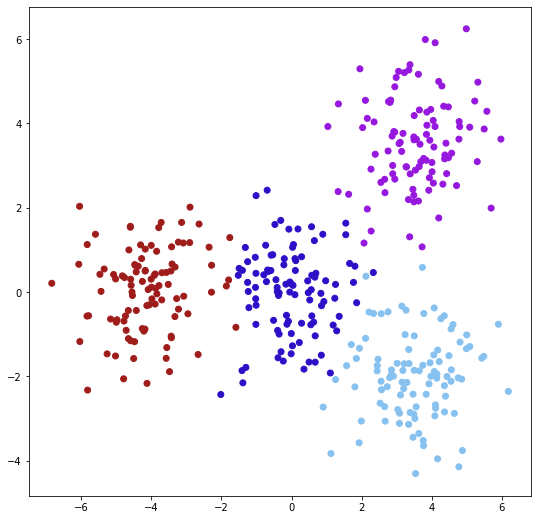

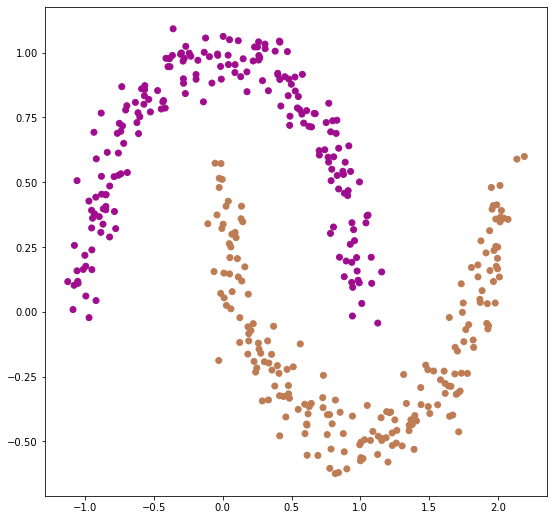

In [16]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 4 (1.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [17]:
class KMeans:
    def __init__(self, n_clusters=2, init="random", eps=0.00001, max_iter=300):
        self.k = n_clusters
        self.eps = eps
        self.max_iter = max_iter
        self.centroids = []
        self.init_mode = init

    def fit(self, data):
        if self.init_mode == 'sample':
            for i in range(self.k):
                self.centroids.append(data[np.random.randint(0, data.shape[0])])
        elif self.init_mode == 'random':
            min_x, min_y = data.min(axis=0)
            max_x, max_y = data.max(axis=0)
            self.centroids = np.array([[random.uniform(min_x, max_x), random.uniform(min_y, max_y)] for i in range (self.k)])
        else:
            self.centroids = np.array([data[random.randint(0, len(data) - 1)]])
            while len(self.centroids) < self.k:
                distances = [(-1) for i in range (len(data))]
                dist_sum = 0
                for index in range(len(data)):
                    for c in self.centroids: 
                        cur_dist = (c[0] - data[index][0]) ** 2 + (c[1] - data[index][1]) ** 2
                        if distances[index] == -1 or distances[index] > cur_dist:
                            distances[index] = cur_dist
                    dist_sum += distances[index]
                random_pointer = random.uniform(0, dist_sum)
                dist_sum = 0
                index_of_new_centroid = -1
            
                while dist_sum < random_pointer:
                    index_of_new_centroid += 1
                    dist_sum+=distances[index_of_new_centroid]
                self.centroids = np.append(self.centroids, [data[index_of_new_centroid]], axis=0)

        for _ in range(self.max_iter):
            classifications = [[] for i in range(self.k)]

            for feature_set in data:
                distances = [np.linalg.norm(feature_set - self.centroids[k]) for k in range(self.k)]
                classification = np.argmin(distances)
                classifications[classification].append(feature_set)

            prev_centroids = deepcopy(self.centroids)

            for k in range(self.k):
                self.centroids[k] = np.average(classifications[k], axis=0)

            optimized = True

            for k in range(self.k):
                original_centroid = prev_centroids[k]
                current_centroid = self.centroids[k]
                if np.linalg.norm(current_centroid - original_centroid) > self.eps:
                    optimized = False

            if optimized:
                break

        return self.centroids

    def predict(self, data):
        predictions = []
        for feature_set in data:
            distances = [np.linalg.norm(feature_set - self.centroids[i]) for i in range(self.k)]
            predictions.append(np.argmin(distances))
        return np.array(predictions)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

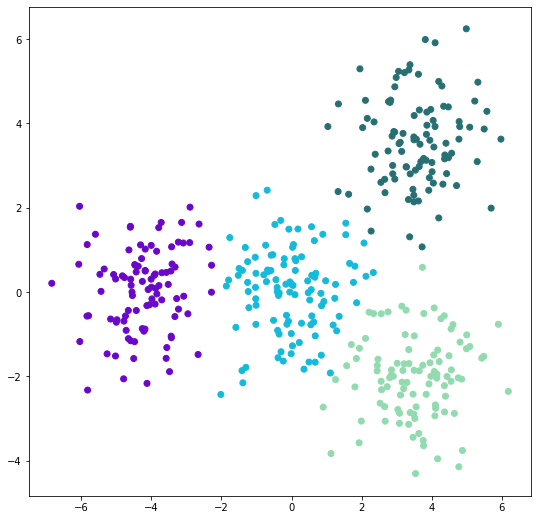

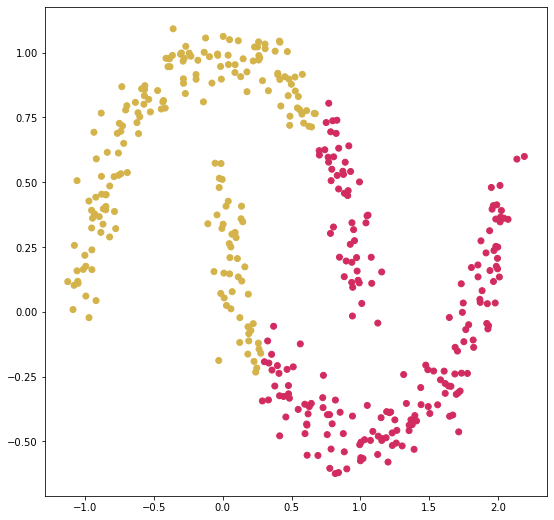

In [18]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 5 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [19]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        

    def fit_predict(self, X, y=None):
        self.X = X
        self.tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        self.X_clusters = [-1 for i in range(len(X))]
        self.index = [i for i in range(len(X))]
        self.X_main = [x >= self.min_samples for x in self.tree.query_radius(X, r=self.eps, count_only=True)]
        c = 0
        for i in range(len(X)):
            if self.X_main[i] and self.X_clusters[i] == -1:
                self.X_clusters[i] = c
                self.dfs(c, X[i])
                c += 1
        return self.X_clusters
    
    def dfs(self, c, x):
        for ind in self.tree.query_radius([x], r=self.eps)[0]:
            i = self.index[ind]
            if  self.X_clusters[i] == -1:
                self.X_clusters[i] = c
                if self.X_main[i]:
                    self.dfs(c, self.X[i])

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

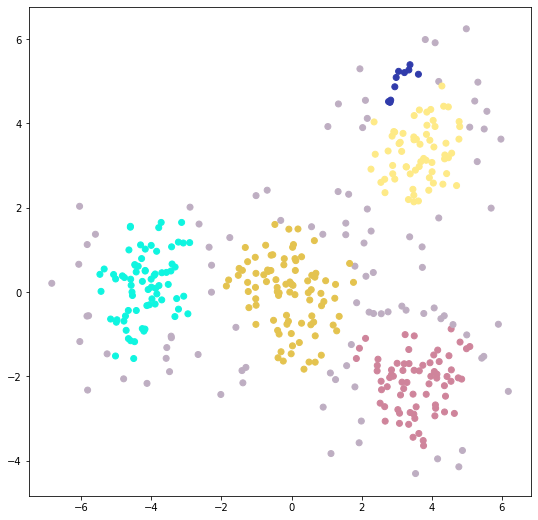

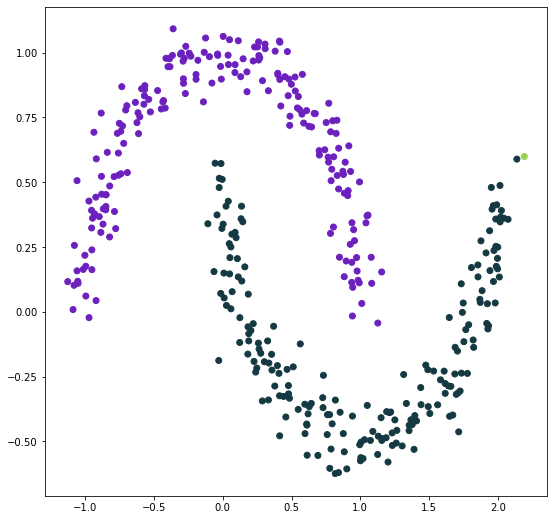

In [20]:
dbscan = DBScan(min_samples=10, eps=0.65)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 6 (0.5 балла)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией каждого из датасетов? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

Известно, что DBScan лучше подходит для датасетов со сложной геометрией (как луны), а к-средних можно укзаать на количество кластеров, что помогло ему с перым датасетом.

Для  `Davies-Bouldin index` -- чем меньше, тем лучше, для `Silhouette score` -- наоброт.

In [21]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [22]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels_kmeans = kmeans.predict(X_1)

dbscan = DBScan(min_samples=10, eps=0.65)
labels_dbscan = dbscan.fit_predict(X_1)

print('For the blobs dataset')
print('Davies-Bouildin score')
print(f'KMeans: {davies_bouldin_score(X_1, labels_kmeans)}')
print(f'DBScan: {davies_bouldin_score(X_1, labels_dbscan)}')
print()
print('Silhouette score ')
print(f'KMeans: {silhouette_score(X_1, labels_kmeans)}')
print(f'DBScan: {silhouette_score(X_1, labels_dbscan)}')

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels_kmeans = kmeans.predict(X_2)

dbscan = DBScan(min_samples=3, eps=0.2)
labels_dbscan = dbscan.fit_predict(X_2)

print('\n\nFor the moons dataset')
print('Davies-Bouildin score')
print(f'KMeans: {davies_bouldin_score(X_1, labels_kmeans)}')
print(f'DBScan: {davies_bouldin_score(X_1, labels_dbscan)}')
print()
print('Silhouette score ')
print(f'KMeans: {silhouette_score(X_1, labels_kmeans)}')
print(f'DBScan: {silhouette_score(X_1, labels_dbscan)}')

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels_kmeans = kmeans.predict(X_2)


For the blobs dataset
Davies-Bouildin score
KMeans: 0.5742670412811416
DBScan: 2.205096157913033

Silhouette score 
KMeans: 0.5709340387184122
DBScan: 0.30596354520522


For the moons dataset
Davies-Bouildin score
KMeans: 13.1441118393388
DBScan: 12.929101043757093

Silhouette score 
KMeans: 0.0018695931354882616
DBScan: 0.0030883910363973532


### Bonus. (3 балла)

#### 1. (2.5 балла)

Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Linkage-функции__

__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [23]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        raise NotImplementedError()
    
    def fit_predict(self, X, y=None):
        raise NotImplementedError()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [24]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

NotImplementedError: 

#### 2. (0.5 балла)

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для `AgglomertiveClustering` с `K-means` и `DBSCAN`. 

Какой из методов лучше произвел кластеризацию данных?

_Ваш ответ_

In [ ]:
# YOUR_CODE

In [ ]:
import numpy as np
rng = np.random.RandomState(0)
X = rng.random_sample((10, 3))  # 10 points in 3 dimensions
X


In [ ]:
tree = KDTree(X, leaf_size=2)         
X[:1]
 # distances to 3 closest neighbors

In [ ]:
dist, ind = tree.query(X[:1], k=3)                
print(dist) 

In [ ]:
for x in X:
    print(x.reshape(1,-1))